### Wide and Deep Learning Model for Yelp Ratings Prediction

### Required packages:

### 1) Pandas
### 2) Numpy
### 3) Math
### 4) Pyspark
### 5) Pytorch
### 6) Pytorch wide and deep - https://github.com/jrzaurin/pytorch-widedeep.git
### 7) Surprise
### 8) Scikit-learn
### 9) Prince
### 10) Matplotlib
### 11) Seaborn

### Commented code snippets were necessary for google_colab, can be ignored

In [0]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
# !wget -q http://mirrors.viethosting.com/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
# !tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [0]:
# !pip install -q findspark

In [0]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [2]:
!pip install git+https://github.com/jrzaurin/pytorch-widedeep.git
!pip install surprise
!pip install prince

  Cloning https://github.com/jrzaurin/pytorch-widedeep.git to /tmp/pip-req-build-842am5j2
  Running command git clone -q https://github.com/jrzaurin/pytorch-widedeep.git /tmp/pip-req-build-842am5j2
  Created wheel for pytorch-widedeep: filename=pytorch_widedeep-0.3.1-cp36-none-any.whl size=45586 sha256=a0eeaea97fdaa6426997f1ae74664a353de003676e3ebc198020c9c8adceaa08
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltwhg9c6/wheels/bb/75/8a/93d73b4fbae4f4e2797938197a6c9ca7b386147b5223cd6d8d
Successfully built pytorch-widedeep
     |████████████████████████████████| 6.5MB 1.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678228 sha256=b24296e328a123b5e20e642adbedaae5006372f3f759c7af6d0555993dd8cc69
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
from pytorch_widedeep.preprocessing import WidePreprocessor, DeepPreprocessor
from pytorch_widedeep.models import Wide, DeepDense, WideDeep
import torch
from sklearn.metrics import mean_squared_error 
from math import sqrt
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [0]:
#import findspark
#findspark.init()
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Functions to compute the goodness_of_fit and normalize continuous data within a 0-1 range

In [0]:
def goodness_of_fit(predictions,ratings):
    avg = np.mean(ratings)
    ss_res = 0
    for i in range(len(predictions)):
        err = (ratings[i]-predictions[i])**2
        ss_res += err
    ss_tot = 0
    for i in range(len(ratings)):
        ss_tot += (ratings[i]-avg)**2
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [0]:
def normalize(df,cont_cols):
    result = df.copy()
    for feature_name in cont_cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [6]:
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load the sample

In [0]:
sample_df = pd.read_csv('dataset/yelp_sampledata_user_biz_feat.csv')
sample_df = sample_df.drop('Unnamed: 0',axis=1)

### We only want to build models and make recommendations for businesses that haven't been shut down

In [0]:
sample_df = sample_df[sample_df['is_open'] == 1]

In [50]:
sample_df.head()

,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,city,is_open,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,Canadian (New),Caterers,Chicken Wings,Chinese,Coffee & Tea,Comfort Food,Delis,Desserts,Ethnic Food,Event Planning & Services,Fast Food,Food Delivery Services,Food Trucks,Grocery,Ice Cream & Frozen Yogurt,Italian,Juice Bars & Smoothies,Mexican,Nightlife,...,Specialty Food,Wine & Spirits,avg_stars,fans,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,biz_w_avg
0,39VYc2nWSdvdTCldsDJ7qw,xqocOGl5Hvjc3hb1r_U4xA,5.0,2015-06-12 13:09:11,0,64478,4.0,116,ON,Mississauga,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3.73,13,0,2,2,1,1,2,1,4,2,3,0,3,0,5,1,2,0,5,4,3,2,0,0,0,0,3,1,1,2,1,3,3,0,4,1,4.042373
1,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,3.0,2014-05-01 19:03:06,0,64478,4.0,116,ON,Mississauga,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3.74,37,2,10,1,16,2,2,4,7,9,8,4,4,8,7,14,5,6,4,11,6,28,2,0,2,3,13,2,5,2,1,1,7,1,16,4,4.042373
2,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,4.0,2017-11-29 22:37:33,4,64478,4.0,116,ON,Mississauga,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3.74,37,2,10,1,16,2,2,4,7,9,8,4,4,8,7,14,5,6,4,11,6,28,2,0,2,3,13,2,5,2,1,1,7,1,16,4,4.042373
3,X4cwQL_JZZnAUyCbOwz3pw,xqocOGl5Hvjc3hb1r_U4xA,2.0,2011-03-28 04:36:34,0,64478,4.0,116,ON,Mississauga,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3.74,37,2,10,1,16,2,2,4,7,9,8,4,4,8,7,14,5,6,4,11,6,28,2,0,2,3,13,2,5,2,1,1,7,1,16,4,4.042373
4,hiCEt6RVMW7kc4pnFDjjXQ,xqocOGl5Hvjc3hb1r_U4xA,4.0,2017-12-13 22:28:31,0,64478,4.0,116,ON,Mississauga,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,3.80,5,0,6,0,3,0,0,0,3,6,1,2,1,2,1,4,2,0,0,1,1,10,0,0,0,1,0,0,1,0,0,0,3,0,1,0,4.042373


### Getting a list of our features - multi-hot encoding of categories of a business for the wide component, and the number of times the user has rated each of these categories for the deep component.

In [0]:
cat_cols = list(sample_df.columns[11:46])
cont_cols = list(sample_df.columns[48:83])

### Giving each user_id and business id a unique number for the ALS baseline and merging with the ratings dataset

In [52]:
users_ids = list(set(sample_df['user_id']))
num_id = [i for i in range(len(users_ids))]
users_dict = {'user_id':users_ids,'user_id_num':num_id}
users_df = pd.DataFrame(users_dict)
users_df.head()

,user_id,user_id_num
0,PwItHyTNp7zzEm1Rm8NFfw,0
1,tLq1YP87NW0W_gKo28GitA,1
2,8al9K4EnKfvxcOC2OsD17w,2
3,QRmQGgtoHBtBGA5NO9ns0g,3
4,NdHGV2JmZmhYG1tSCRwrBg,4


In [0]:
sample_df = sample_df.merge(users_df)

In [54]:
biz_ids = list(set(sample_df['business_id']))
num_id_biz = [i for i in range(len(biz_ids))]
biz_dict = {'business_id':biz_ids,'business_id_num':num_id_biz}
biz_df = pd.DataFrame(biz_dict)
biz_df.head()

,business_id,business_id_num
0,DuDZ4FZ_UxGQ-3GPuk8iJw,0
1,GQOvHuqaFMLZQ1-EfFEJnw,1
2,4Z7MEDgJU6kjCcJA4mfQeQ,2
3,qtsIl9bBtsbxIGK5Zf_F-g,3
4,Ss37i4feOgX1N3Z_h5wy9A,4


In [0]:
sample_df = sample_df.merge(biz_df)

### Sorting the reviews for each user by date, and picking the last review of each user for the test set and the rest for training set

In [0]:
sorted_sample = sample_df.groupby(["user_id"]).apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)

In [0]:
test = sorted_sample.groupby(["user_id"]).tail(1)
train = pd.concat([sample_df, test, test]).drop_duplicates(keep=False)

### Pick a sample of 500 business' from the test dataset for testing the recommendations and evalutating the coverage (making predictions for all every business was not feasible)

In [0]:
test_city = test[['business_id']].drop_duplicates()
test_city = test_city.sample(n=500,random_state = 69)

### Create a dataset of future predictions to be made by performing the following steps:  
### 1) Assign to each user a city, which is the most frequently occurring city on his last 5 visits   
### 2) For each user select select those businesses in his city to make predictions  
### 3) Remove those user-business combinations which the user has already rated

In [0]:
pred_data = sorted_sample.groupby(["user_id"]).tail(5)
user_city = pred_data.groupby(['user_id'])['city'].apply(lambda x: x.value_counts().index[0]).reset_index()
biz_city = sample_df[['business_id','city']].drop_duplicates()
biz_city = biz_city.merge(test_city)
user_business_pred = user_city.merge(biz_city)
user_business_pred = user_business_pred.drop(columns = ['city'])

In [0]:
already_reviewed = sample_df[['user_id','business_id']]
not_reviewed_sample = pd.concat([user_business_pred, already_reviewed, already_reviewed]).drop_duplicates(keep=False)

### For the future prediction dataset, add user and business information which will be used by the model

In [61]:
user_cols = ['user_id','user_id_num','avg_stars','fans']
user_cols.extend(cont_cols)
user_sub  = sample_df[user_cols].drop_duplicates()
not_reviewed_sample = not_reviewed_sample.merge(user_sub)
not_reviewed_sample.head()

,user_id,business_id,user_id_num,avg_stars,fans,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating
0,---1lKK3aKOuomHnwAkAow,po0p6NIro0cDrmKkcyPy0w,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1
1,---1lKK3aKOuomHnwAkAow,BcW7Z9lPmOB_8eS2lEuOqQ,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1
2,---1lKK3aKOuomHnwAkAow,rioQ_p2pILNbJ4Xp5jW6-Q,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1
3,---1lKK3aKOuomHnwAkAow,-a857YYdjzgOdOjFFRsRXQ,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1
4,---1lKK3aKOuomHnwAkAow,rt-aQTkNfILbxBuATdJ1dA,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1


In [0]:
biz_cols = ['business_id','business_id_num','state','city','biz_stars','biz_rev_ct','is_open','biz_w_avg']
biz_cols.extend(cat_cols)

In [63]:
biz_sub = sample_df[biz_cols].drop_duplicates()
not_reviewed_sample = not_reviewed_sample.merge(biz_sub)
not_reviewed_sample.head()

,user_id,business_id,user_id_num,avg_stars,fans,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,...,city,biz_stars,biz_rev_ct,is_open,biz_w_avg,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,Canadian (New),Caterers,Chicken Wings,Chinese,Coffee & Tea,Comfort Food,Delis,Desserts,Ethnic Food,Event Planning & Services,Fast Food,Food Delivery Services,Food Trucks,Grocery,Ice Cream & Frozen Yogurt,Italian,Juice Bars & Smoothies,Mexican,Nightlife,Pizza,Salad,Sandwiches,Seafood,Specialty Food,Wine & Spirits
0,---1lKK3aKOuomHnwAkAow,po0p6NIro0cDrmKkcyPy0w,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,Las Vegas,4.5,415,1,4.083527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,--LUapetRSkZpFZ2d-MXLQ,po0p6NIro0cDrmKkcyPy0w,40438,4.91,0,2,0,0,0,0,1,0,3,0,4,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,Las Vegas,4.5,415,1,4.083527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,--RlSfc-QmcHFGHyX6aVjA,po0p6NIro0cDrmKkcyPy0w,25470,3.69,15,7,6,4,0,1,5,2,8,3,1,0,0,0,2,2,1,1,6,1,0,1,1,0,0,1,3,3,0,5,1,2,2,1,4,2,...,Las Vegas,4.5,415,1,4.083527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,--ZNfWKj1VyVElRx6-g1fg,po0p6NIro0cDrmKkcyPy0w,45529,3.82,37,5,2,2,1,0,5,4,0,4,0,0,0,0,0,0,2,1,1,0,1,0,0,0,0,0,0,2,0,5,0,1,2,1,0,4,...,Las Vegas,4.5,415,1,4.083527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-00kdEIhCt-ODaV4BS-EAg,po0p6NIro0cDrmKkcyPy0w,8822,3.14,6,4,1,0,0,1,2,1,3,0,0,0,2,1,0,2,1,0,2,0,2,1,1,0,0,0,0,0,0,2,1,4,4,0,0,1,...,Las Vegas,4.5,415,1,4.083527,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Wide and Deep

### Specify the columns to be used by the wide and deep model.
### For the wide component of the model, we consider the columns representing multi-hot encoding of the businesses, which encodes all the categories a business belongs to.

In [65]:
wide_pre = WidePreprocessor(wide_cols=cat_cols)
X_wide = wide_pre.fit_transform(train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### We use state and city as our categorical embeddings which will encode location information and be used as a part of the deep component of the model

In [0]:
cat_embed_cols = [(c, 16) for c in ['state','city']]

### For the continuous columns, we initially build a model without our derived features which contains user information about how many times the user has rated each of the business categories. The continuous columns we use are average user rating, the number of fans a user has, the number of ratings a business has, the average business rating, the weighted average business rating, where each review is weighted on how many people thought that review was useful

In [0]:
continuous_cols = ['avg_stars','fans','biz_rev_ct','biz_stars','biz_w_avg']
train = normalize(train,continuous_cols)
deep_pre = DeepPreprocessor(continuous_cols=continuous_cols,embed_cols=cat_embed_cols)
X_deep = deep_pre.fit_transform(train)

### Create the wide and deep components and build an initial model

In [0]:
wide_component = Wide(wide_dim=X_wide.shape[1], output_dim=1)
deep_component = DeepDense(hidden_layers=[128,64], dropout=[0.5, 0.5], 
                      deep_column_idx=deep_pre.deep_column_idx,
                      embed_input=deep_pre.embeddings_input,
                      continuous_cols=continuous_cols)

In [73]:
wide_pre = WidePreprocessor(wide_cols=cat_cols)
X_wide = wide_pre.fit_transform(train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
target_rating = train['rating'].values

In [75]:
model = WideDeep(wide=wide_component, deepdense=deep_component)
model.compile(method='regression') 
model.fit(X_wide=X_wide, X_deep=X_deep, target=target_rating, n_epochs=5, batch_size=256, val_split=0.2)

  0%|          | 0/1517 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 380/380 [00:02<00:00, 154.80it/s, loss=1.02]


### We now try to add our derived continuous features (features regarding the number of times the user has rated each of the categories we considered) to see if it improves our model. Although our model should be able to learn this implicitly, we want to test this by feeding the information explicitly as well

In [0]:
continuous_cols_new = ['avg_stars','fans','biz_rev_ct','biz_stars','biz_w_avg']
continuous_cols_new.extend(cont_cols)
deep_pre_new = DeepPreprocessor(continuous_cols=continuous_cols_new,embed_cols=cat_embed_cols)
X_deep_new = deep_pre_new.fit_transform(train) 
deep_component_new = DeepDense(hidden_layers=[128,64], dropout=[0.5, 0.5], 
                      deep_column_idx=deep_pre_new.deep_column_idx,
                      embed_input=deep_pre_new.embeddings_input,
                      continuous_cols=continuous_cols_new)

In [39]:
model_new = WideDeep(wide=wide_component, deepdense=deep_component)
model_new.compile(method='regression')
model_new.fit(X_wide=X_wide, X_deep=X_deep, target=target_rating, n_epochs=5, batch_size=256, val_split=0.2)

  0%|          | 0/1517 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 380/380 [00:02<00:00, 150.62it/s, loss=1.02]


### We see a very small improvement of 0.01 on the validation loss by including our derived features in the model

### Perform a grid search on the model, varying the number of hidden layers, the number of neurons in each hidden layer, the dropouts and the maximum learning rate

In [72]:
hidden_layer_set = [[64,32],[128,64],[64,32,16],[128,64,32]]
dropout_set = [[0.2,0.2],[0.5,0.5],[0.2,0.2,0.2],[0.5,0.5,0.5]]
warm_lrs = [0.01,0.1,1]

for i in hidden_layer_set:
  for j in dropout_set:
    for k in warm_lrs:
      if(len(i) == len(j)):
        print("Hidden Layer",i,"Dropout",j,"Max Learning Rate",k)
        deep_component_grid = DeepDense(hidden_layers=i, dropout=j, 
                      deep_column_idx=deep_pre.deep_column_idx,
                      embed_input=deep_pre.embeddings_input,
                      continuous_cols=continuous_cols)
        model_grid = WideDeep(wide=wide_component, deepdense=deep_component_grid)
        model_grid.compile(method='regression')
        model_grid.fit(X_wide=X_wide, X_deep=X_deep, target=target_rating, n_epochs=5, batch_size=256, val_split=0.2, warm_max_lr = k)

        print("\n\n")

  0%|          | 0/1517 [00:00<?, ?it/s]

Hidden Layer [64, 32] Dropout [0.2, 0.2] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32] Dropout [0.2, 0.2] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32] Dropout [0.2, 0.2] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32] Dropout [0.5, 0.5] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32] Dropout [0.5, 0.5] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32] Dropout [0.5, 0.5] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.2, 0.2] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.2, 0.2] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.2, 0.2] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.5, 0.5] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.5, 0.5] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64] Dropout [0.5, 0.5] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.2, 0.2, 0.2] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.2, 0.2, 0.2] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.2, 0.2, 0.2] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.5, 0.5, 0.5] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.5, 0.5, 0.5] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [64, 32, 16] Dropout [0.5, 0.5, 0.5] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.2, 0.2, 0.2] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.2, 0.2, 0.2] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.2, 0.2, 0.2] Max Learning Rate 1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.5, 0.5, 0.5] Max Learning Rate 0.01
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.5, 0.5, 0.5] Max Learning Rate 0.1
Training


  0%|          | 0/1517 [00:00<?, ?it/s]




Hidden Layer [128, 64, 32] Dropout [0.5, 0.5, 0.5] Max Learning Rate 1
Training


valid: 100%|██████████| 380/380 [00:02<00:00, 154.19it/s, loss=1.02]


### Since the gridsearch reveals that all the models are converging to nearly the same value, we test out a significantly more complex model with a larger number of epochs to see if it makes any difference

In [30]:
deep_component_complex = DeepDense(hidden_layers=[256,128,64,32,16], dropout=[0.5,0.5,0.5,0.5,0.5], 
                      deep_column_idx=deep_pre.deep_column_idx,
                      embed_input=deep_pre.embeddings_input,
                      continuous_cols=continuous_cols)
model_complex = WideDeep(wide=wide_component, deepdense=deep_component_complex)
model_complex.compile(method='regression')
model_complex.fit(X_wide=X_wide, X_deep=X_deep, target=target_rating, n_epochs=20, batch_size=256, val_split=0.2)

  0%|          | 0/1517 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 380/380 [00:02<00:00, 140.81it/s, loss=1.03]


### Seeing that even a complex model doesn't converge to a lower value, we feel that either the model has converged to a global minima or is completely stuck at a local minima.  
  

### We will now attempt to see if MCA for categorical data and PCA for continuous data improves our model

In [11]:
mca_input = sample_df.iloc[:, 11:46]
mca_input.shape

(629155, 35)

In [12]:
mca = prince.MCA()
mca = mca.fit(mca_input)
mca = mca.transform(mca_input)

/usr/local/lib/python3.6/dist-packages/prince/one_hot.py:35: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=0
/usr/local/lib/python3.6/dist-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/use

In [13]:
mca

,0,1
0,-0.108593,-0.085034
1,-0.108593,-0.085034
2,-0.108593,-0.085034
3,-0.108593,-0.085034
4,-0.108593,-0.085034
...,...,...
629150,-0.203822,-0.329396
629151,-0.190466,-0.037866
629152,-0.200035,0.275217
629153,-0.181261,-0.089580


In [0]:
x = mca
x.columns  = ["mca_0", "mca_1"]

In [0]:
sample_df_mca = sample_df.drop(mca_input.columns, axis=1)
sample_df_mca = pd.concat([sample_df_mca, x], axis = 1)

### We now run PCA on the continuous derived columns from our data

In [25]:
pca_input = sample_df_mca
pca_input = pca_input.iloc[:, 13:48]
pca_input.columns

Index(['American (New)_urating', 'American (Traditional)_urating',
       'Asian Fusion_urating', 'Bakeries_urating', 'Barbeque_urating',
       'Bars_urating', 'Beer_urating', 'Breakfast & Brunch_urating',
       'Burgers_urating', 'Cafes_urating', 'Canadian (New)_urating',
       'Caterers_urating', 'Chicken Wings_urating', 'Chinese_urating',
       'Coffee & Tea_urating', 'Comfort Food_urating', 'Delis_urating',
       'Desserts_urating', 'Ethnic Food_urating',
       'Event Planning & Services_urating', 'Fast Food_urating',
       'Food Delivery Services_urating', 'Food Trucks_urating',
       'Grocery_urating', 'Ice Cream & Frozen Yogurt_urating',
       'Italian_urating', 'Juice Bars & Smoothies_urating', 'Mexican_urating',
       'Nightlife_urating', 'Pizza_urating', 'Salad_urating',
       'Sandwiches_urating', 'Seafood_urating', 'Specialty Food_urating',
       'Wine & Spirits_urating'],
      dtype='object')

In [0]:
rem_col = pca_input.columns
x = StandardScaler().fit_transform(pca_input)

In [0]:
pca = PCA(0.9)
x_pca = pca.fit_transform(x)

In [28]:
y = pd.DataFrame(x_pca)
x = pd.DataFrame(x)
y.columns = ["0", "1", "2", "3", "4", "5", "6", "7"]
y

,0,1,2,3,4,5,6,7
0,-0.948668,0.638133,-0.239582,0.270283,-0.139004,0.200492,-0.044248,-0.281905
1,3.591542,1.712071,-2.624083,-1.985745,-0.572222,0.547910,-0.468460,-0.235378
2,3.591542,1.712071,-2.624083,-1.985745,-0.572222,0.547910,-0.468460,-0.235378
3,3.591542,1.712071,-2.624083,-1.985745,-0.572222,0.547910,-0.468460,-0.235378
4,-1.592281,0.288642,-0.826040,-0.821081,-0.030283,-0.337374,0.462973,-0.325721
...,...,...,...,...,...,...,...,...
629150,-2.462857,0.413204,-0.175365,0.165764,-0.149523,0.075979,0.043790,0.063523
629151,-2.073629,0.020520,-0.234244,0.086786,-0.439905,0.067149,0.205278,0.123721
629152,-2.356660,0.296786,-0.076045,0.405830,-0.381375,-0.144247,0.195368,0.323844
629153,-2.127581,-0.062405,-0.121323,-0.161403,-0.136415,0.153337,0.063302,-0.087123


In [29]:
print(x.shape)
print(x_pca.shape)

(629155, 35)
(629155, 8)


In [0]:
sample_df_new = sample_df_mca.drop(rem_col, axis = 1)
sample_df_new = pd.concat([sample_df_new, y], axis = 1)

In [31]:
sample_df_new.columns

Index(['user_id', 'business_id', 'rating', 'date', 'useful', 'index',
       'biz_stars', 'biz_rev_ct', 'state', 'city', 'is_open', 'avg_stars',
       'fans', 'biz_w_avg', 'mca_0', 'mca_1', '0', '1', '2', '3', '4', '5',
       '6', '7'],
      dtype='object')

### We now define our continuous columns and create our train-test split as we did for the original data in order to run the model on the PCA data

In [32]:
cont_cols_pca = ["0", "1", "2", "3", "4", "5", "6", "7", "mca_0", "mca_1"]
cont_cols_pca

['0', '1', '2', '3', '4', '5', '6', '7', 'mca_0', 'mca_1']

In [0]:
sample_df_new_sorted = sample_df_new.groupby(["user_id"]).apply(pd.DataFrame.sort_values, 'date').reset_index(drop=True)

In [0]:
test_new = sample_df_new_sorted.groupby(["user_id"]).tail(1)
train_new = pd.concat([sample_df_new, test_new, test_new]).drop_duplicates(keep=False)

### We now build and test our model on this new data

In [0]:
wide_pre_pca = WidePreprocessor(['state'])
X_wide_pca = wide_pre_pca.fit_transform(train_new)

In [0]:
cat_embed_cols_pca = [(c, 16) for c in ['state','city']]

In [0]:
continuous_cols_pca = ['avg_stars','fans','biz_rev_ct','biz_stars','biz_w_avg']
train = normalize(train_new,continuous_cols_pca)
continuous_cols_pca.extend(cont_cols_pca)
deep_pre_pca = DeepPreprocessor(continuous_cols=continuous_cols_pca, embed_cols=cat_embed_cols_pca)
X_deep_pca = deep_pre_pca.fit_transform(train_new)

In [0]:
# Linear model
wide_pca = Wide(wide_dim=X_wide_pca.shape[1], output_dim=1)
# DeepDense: 2 Dense layers
deep_pca = DeepDense(hidden_layers=[128, 64], dropout=[0.5, 0.5], 
                      deep_column_idx=deep_pre_pca.deep_column_idx,
                      embed_input=deep_pre_pca.embeddings_input,
                      continuous_cols=continuous_cols_pca)

In [0]:
target_pca = train_new['rating'].values

In [46]:
model_pca = WideDeep(wide = wide_pca, deepdense=deep_pca)
model_pca.compile(method='regression')
model_pca.fit(X_wide=X_wide_pca, X_deep=X_deep_pca, target=target_pca, n_epochs=5, batch_size=256, val_split=0.2)

  0%|          | 0/1802 [00:00<?, ?it/s]

Training


valid: 100%|██████████| 451/451 [00:02<00:00, 172.96it/s, loss=1.03]


### We see that even PCA does not improve our model any further.

### Hence we stick to our original model and test the model on the test set and compute RMSE and R2

In [32]:
X_wide_te = wide_pre.fit_transform(test)
test_1 = normalize(test,continuous_cols)
X_deep_te = deep_pre.fit_transform(test_1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [33]:
preds = model.predict(X_wide=X_wide_te, X_deep=X_deep_te)

predict: 100%|██████████| 206/206 [00:01<00:00, 198.22it/s]


In [44]:
import math
rmse = math.sqrt(mean_squared_error(preds, test['rating']))
print("RMSE =",rmse)
print("R2 = ",goodness_of_fit(preds,np.array(test['rating'])))

RMSE = 1.1162710090612755
R2 =  0.3232816792958726


### We see that our model's performance on the test data is consistent with the results on  the training and validation loss.  
### We now fit the model on our future predictions dataset and get predicted ratings for all the future predictions

In [76]:
X_wide_recs = wide_pre.fit_transform(not_reviewed_sample)
not_reviewed_1 = normalize(not_reviewed_sample,continuous_cols)
X_deep_recs = deep_pre.fit_transform(not_reviewed_1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [77]:
recs = model.predict(X_wide=X_wide_recs, X_deep=X_deep_recs)
not_reviewed_sample['pred_rating'] = recs

predict: 100%|██████████| 8072/8072 [00:31<00:00, 258.94it/s]


### For each user, get the top 5 recommendations and compute catalog coverage

In [78]:
top_5 = not_reviewed_sample.groupby(["user_id"]).apply(pd.DataFrame.sort_values, 'pred_rating').reset_index(drop=True)
top_5_recs = top_5.groupby(["user_id"]).tail(5)
top_5_recs.head()

,user_id,business_id,user_id_num,avg_stars,fans,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,...,biz_stars,biz_rev_ct,is_open,biz_w_avg,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,Canadian (New),Caterers,Chicken Wings,Chinese,Coffee & Tea,Comfort Food,Delis,Desserts,Ethnic Food,Event Planning & Services,Fast Food,Food Delivery Services,Food Trucks,Grocery,Ice Cream & Frozen Yogurt,Italian,Juice Bars & Smoothies,Mexican,Nightlife,Pizza,Salad,Sandwiches,Seafood,Specialty Food,Wine & Spirits,pred_rating
64,---1lKK3aKOuomHnwAkAow,wWuGa3OOQJro_XGe-GKBXA,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,4.5,601,1,4.694737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.443210
65,---1lKK3aKOuomHnwAkAow,4zqoILJLZ-3F8VVNr2hg1w,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,4.5,46,1,4.555556,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.443450
66,---1lKK3aKOuomHnwAkAow,KTzBUAzUfFqvttyjWi_irw,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,4.5,35,1,4.485294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,4.444250
67,---1lKK3aKOuomHnwAkAow,fia9wLvJYq54MCkMxH9_wA,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,4.5,47,1,4.772727,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.485538
68,---1lKK3aKOuomHnwAkAow,JDv3HcmwK0cPkRa0-2aP4Q,6027,3.92,16,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,...,5.0,5,1,5.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.715500


In [79]:
print("Catalog Coverage for the sample:",(len(set(top_5_recs['business_id']))/len(set(not_reviewed_sample['business_id'])))*100,"%")

Catalog Coverage for the sample: 52.066115702479344 %


### Hence we are able to recommend around half the businesses to a user, which is a good figure.  
  
  ### However, we try to improve the coverage by implementing this simple business rule - 
  ### We take all the businesses that have not been recommended to any user and have a rating of above 3.5, and randomly recommend 3 of these businesses from the user's city additionally to each user. This will simultaneously not only improve the coverage, but will also improve serendipity, since our model is trained towards a user's preference and this will enable us to recommend good businesses that  are outside a user's normal taste.

In [0]:
not_recommended = list(set(not_reviewed_sample['business_id']).difference(set(top_5_recs['business_id'])))
not_recommended = pd.DataFrame({'business_id':not_recommended})

In [82]:
not_recommended_good = not_reviewed_sample[['business_id','biz_stars','biz_rev_ct','city']].drop_duplicates()
not_recommended_good = not_recommended_good.merge(not_recommended)
not_recommended_good = not_recommended_good[not_recommended_good['biz_stars'] >= 3.5]
not_recommended_good.head()

,business_id,biz_stars,biz_rev_ct,city
0,po0p6NIro0cDrmKkcyPy0w,4.5,415,Las Vegas
1,BcW7Z9lPmOB_8eS2lEuOqQ,4.0,683,Las Vegas
2,rioQ_p2pILNbJ4Xp5jW6-Q,4.0,787,Las Vegas
3,-a857YYdjzgOdOjFFRsRXQ,3.5,536,Las Vegas
4,rt-aQTkNfILbxBuATdJ1dA,3.5,258,Las Vegas


### We now recommend 3 of these businesses to each user and compute our new catalog coverage.

In [83]:
users_rec = not_reviewed_sample[['user_id','city']].drop_duplicates()
users_rec.head()

,user_id,city
0,---1lKK3aKOuomHnwAkAow,Las Vegas
1,--LUapetRSkZpFZ2d-MXLQ,Las Vegas
2,--RlSfc-QmcHFGHyX6aVjA,Las Vegas
3,--ZNfWKj1VyVElRx6-g1fg,Las Vegas
4,-00kdEIhCt-ODaV4BS-EAg,Las Vegas


In [0]:
not_recommended_good_subset = not_recommended_good.merge(users_rec)

In [0]:
not_recommended_good_subset = not_recommended_good_subset.sample(frac = 1, random_state = 69)

In [92]:
new_recs = not_recommended_good_subset.groupby('user_id').head(3).reset_index(drop=True)
new_recs.head()

,business_id,biz_stars,biz_rev_ct,city,user_id
0,po0p6NIro0cDrmKkcyPy0w,4.5,415,Las Vegas,RepuhCglksbbZp4SY8VzFA
1,DYAorbxOyubUB_wtQRCdug,4.0,861,Las Vegas,4DprYqnBy1b5iKzhJWzczQ
2,USMzHt3XL3nPXVVOfRw1-g,3.5,103,Las Vegas,YM053Px-v4iuuYL4F6iIIg
3,Z0CQ9oJySxJpB8RbK6NUgg,3.5,191,Las Vegas,LUpPyHnDlQOm9F4GCKcuHA
4,sJBem81QF7l_43aF7xtLYQ,4.0,138,Las Vegas,5dLAmXWDYb9OAswtNHyVdQ


In [94]:
print("Modified Catalog Coverage for the sample:",((len(set(top_5_recs['business_id']))+len(set(new_recs['business_id'])))/len(set(not_reviewed_sample['business_id'])))*100,"%")

Modified Catalog Coverage for the sample: 78.51239669421489 %


### We see that the catalog coverage now improves to 78%, hence significantly improving coverage as well.

### Finally, we want to test how our model performs with respect to less and more prolific businesses and users

### First, we split the businesses into 4 categories (<10 reviews, 10-100 reviews, 100-1000 reviews and above 1000 reviews) and compute RMSE and R2 for each of them

In [0]:
test['predicted_rating'] = preds

In [42]:
biz_cat = []
for i in range(len(test)):
  if test.iloc[i]['biz_rev_ct'] <= 10:
    biz_cat.append(1)
  elif test.iloc[i]['biz_rev_ct'] > 10 and  test.iloc[i]['biz_rev_ct'] <= 100:
    biz_cat.append(2)
  elif test.iloc[i]['biz_rev_ct'] > 100 and  test.iloc[i]['biz_rev_ct'] <= 1000:
    biz_cat.append(3)
  elif test.iloc[i]['biz_rev_ct'] > 1000:
    biz_cat.append(4)
  
test['biz_cat'] = biz_cat
test.head()

,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,city,is_open,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,Canadian (New),Caterers,Chicken Wings,Chinese,Coffee & Tea,Comfort Food,Delis,Desserts,Ethnic Food,Event Planning & Services,Fast Food,Food Delivery Services,Food Trucks,Grocery,Ice Cream & Frozen Yogurt,Italian,Juice Bars & Smoothies,Mexican,Nightlife,...,American (New)_urating,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,biz_w_avg,user_id_num,business_id_num,predicted_rating,biz_cat
10,---1lKK3aKOuomHnwAkAow,GJBLjDkfJ4tvkpAjDeCikA,1.0,2018-07-05 19:14:18,3,176121,2.0,130,NV,Las Vegas,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,1.743590,45925,12403,2.737375,3
29,--2HUmLkcNHZp0xw6AMBPg,EU83r5yrRw3zRictM5eO6Q,5.0,2018-09-23 19:48:17,0,142137,4.0,18,AZ,Phoenix,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,4,3,0,3,0,1,1,7,3,1,0,1,1,0,3,1,3,2,0,1,7,0,0,1,2,4,2,5,1,1,0,7,1,1,1,4.500000,22775,237,4.597207,2
34,--3WaS23LcIXtxyFULJHTA,WB7346WSdkTHvtHfWPilaA,5.0,2018-04-27 20:34:01,1,181182,4.5,334,AZ,Phoenix,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,2,0,3,0,4,0,1,0,0,3,0,0,1,0,1,0,1,0,1,0,0,0,0,2,0,2,3,0,0,0,4.487805,10751,11892,4.243849,3
40,--4rAAfZnEIAKJE80aIiYg,9h2FCxdB5uk4bjX3P47L9g,3.0,2018-04-01 23:27:32,0,67964,4.0,88,AZ,Phoenix,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,1,0,2,0,1,0,0,3,1,0,0,1,0,2,1,0,2,0,0,1,4,0,0,0,0,1,0,0,0,1,1,3,0,0,0,3.884615,12563,3610,2.909734,2
62,--BumyUHiO_7YsHurb9Hkw,3fw2X5bZYeW9xCz_zGhOHg,4.0,2018-08-27 01:26:21,0,2756,3.5,122,ON,Markham,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,3,0,4,2,5,0,6,3,1,0,3,9,1,0,6,2,2,1,0,0,0,0,1,0,3,4,1,2,6,0,5,2,3.464912,33938,6523,3.707530,3


In [46]:
for i in range(1,5):
  test_sample = test[test['biz_cat'] == i]
  rmse = math.sqrt(mean_squared_error(test_sample['predicted_rating'], test_sample['rating']))
  r2 = goodness_of_fit(np.array(test_sample['predicted_rating']),np.array(test_sample['rating']))
  print("Business Category: ",i,"RMSE: ",rmse,"R2: ",r2)

  

Business Category:  1 RMSE:  1.085685749666527 R2:  0.4938705358242176
Business Category:  2 RMSE:  1.1709984356405985 R2:  0.38457248542269595
Business Category:  3 RMSE:  1.1154534111284893 R2:  0.24389463491990504
Business Category:  4 RMSE:  1.0191824213146938 R2:  0.1568331334647005


### We see that although there is a variation in the RMSE and R2 for all for categories, they all have good values that perform better than the baselines  
  
  ### Now, similarly, we will split users using the same bins into 4 categories based on the number of fans a user has

In [50]:
user_cat = []
for i in range(len(test)):
  if test.iloc[i]['fans'] <= 10:
    user_cat.append(1)
  elif test.iloc[i]['fans'] > 10 and  test.iloc[i]['fans'] <= 100:
    user_cat.append(2)
  elif test.iloc[i]['fans'] > 100 and  test.iloc[i]['fans'] <= 1000:
    user_cat.append(3)
  elif test.iloc[i]['fans'] > 1000:
    user_cat.append(4)
  
test['user_cat'] = user_cat
test.head()

,user_id,business_id,rating,date,useful,index,biz_stars,biz_rev_ct,state,city,is_open,American (New),American (Traditional),Asian Fusion,Bakeries,Barbeque,Bars,Beer,Breakfast & Brunch,Burgers,Cafes,Canadian (New),Caterers,Chicken Wings,Chinese,Coffee & Tea,Comfort Food,Delis,Desserts,Ethnic Food,Event Planning & Services,Fast Food,Food Delivery Services,Food Trucks,Grocery,Ice Cream & Frozen Yogurt,Italian,Juice Bars & Smoothies,Mexican,Nightlife,...,American (Traditional)_urating,Asian Fusion_urating,Bakeries_urating,Barbeque_urating,Bars_urating,Beer_urating,Breakfast & Brunch_urating,Burgers_urating,Cafes_urating,Canadian (New)_urating,Caterers_urating,Chicken Wings_urating,Chinese_urating,Coffee & Tea_urating,Comfort Food_urating,Delis_urating,Desserts_urating,Ethnic Food_urating,Event Planning & Services_urating,Fast Food_urating,Food Delivery Services_urating,Food Trucks_urating,Grocery_urating,Ice Cream & Frozen Yogurt_urating,Italian_urating,Juice Bars & Smoothies_urating,Mexican_urating,Nightlife_urating,Pizza_urating,Salad_urating,Sandwiches_urating,Seafood_urating,Specialty Food_urating,Wine & Spirits_urating,biz_w_avg,user_id_num,business_id_num,predicted_rating,biz_cat,user_cat
10,---1lKK3aKOuomHnwAkAow,GJBLjDkfJ4tvkpAjDeCikA,1.0,2018-07-05 19:14:18,3,176121,2.0,130,NV,Las Vegas,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,1,2,0,5,1,6,2,4,0,0,0,0,4,0,0,2,0,0,0,0,0,0,1,3,4,0,5,2,0,5,3,2,1,1.743590,45925,12403,2.737375,3,2
29,--2HUmLkcNHZp0xw6AMBPg,EU83r5yrRw3zRictM5eO6Q,5.0,2018-09-23 19:48:17,0,142137,4.0,18,AZ,Phoenix,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,3,0,3,0,1,1,7,3,1,0,1,1,0,3,1,3,2,0,1,7,0,0,1,2,4,2,5,1,1,0,7,1,1,1,4.500000,22775,237,4.597207,2,1
34,--3WaS23LcIXtxyFULJHTA,WB7346WSdkTHvtHfWPilaA,5.0,2018-04-27 20:34:01,1,181182,4.5,334,AZ,Phoenix,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,2,0,3,0,4,0,1,0,0,3,0,0,1,0,1,0,1,0,1,0,0,0,0,2,0,2,3,0,0,0,4.487805,10751,11892,4.243849,3,2
40,--4rAAfZnEIAKJE80aIiYg,9h2FCxdB5uk4bjX3P47L9g,3.0,2018-04-01 23:27:32,0,67964,4.0,88,AZ,Phoenix,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,2,0,1,0,0,3,1,0,0,1,0,2,1,0,2,0,0,1,4,0,0,0,0,1,0,0,0,1,1,3,0,0,0,3.884615,12563,3610,2.909734,2,1
62,--BumyUHiO_7YsHurb9Hkw,3fw2X5bZYeW9xCz_zGhOHg,4.0,2018-08-27 01:26:21,0,2756,3.5,122,ON,Markham,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,3,0,4,2,5,0,6,3,1,0,3,9,1,0,6,2,2,1,0,0,0,0,1,0,3,4,1,2,6,0,5,2,3.464912,33938,6523,3.707530,3,1


In [51]:
for i in range(1,5):
  test_sample = test[test['user_cat'] == i]
  rmse = math.sqrt(mean_squared_error(test_sample['predicted_rating'], test_sample['rating']))
  r2 = goodness_of_fit(np.array(test_sample['predicted_rating']),np.array(test_sample['rating']))
  print("User Category: ",i,"RMSE: ",rmse,"R2: ",r2)

User Category:  1 RMSE:  1.1512816464203068 R2:  0.3247260210144013
User Category:  2 RMSE:  0.9720165668906259 R2:  0.2315928141290836
User Category:  3 RMSE:  0.8390810966687523 R2:  0.2200415183189549
User Category:  4 RMSE:  0.7878254268045792 R2:  0.15483383404961037


### We make similar observations when we split the data based on the user category, and see that although there is a variation in the performance of the model, the model can perform well for all types of users

# ALS Baseline

### We now build an ALS baseline model by running a grid search on the ALS parameters, selecting the best model and computing its RMSE and R2

In [0]:
train_baseline = train[['user_id_num','business_id_num','rating']]
test_baseline = test[['user_id_num','business_id_num','rating']]

In [0]:
spark_train = spark.createDataFrame(train_baseline)
spark_test = spark.createDataFrame(test_baseline)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [59]:
regParams = [0.002,0.02,0.2,2]
ranks = [5,10,20]
l1 = []
for j in regParams:
  for k in ranks:
    als = ALS(maxIter=5, regParam=j, rank = k, userCol="user_id_num", itemCol="business_id_num", ratingCol="rating",
              coldStartStrategy="drop", nonnegative=True)
    model = als.fit(spark_train)
      # Evaluate the model by computing the R2 on the test data
    predictions = model.transform(spark_test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    l1.append([j,k,rmse])
    print("Reg_param:",j,"Rank:",k,"Loss (RMSE):",rmse)      


Reg_param: 0.002 Rank: 5 Loss (RMSE): 2.4719275213916947
Reg_param: 0.002 Rank: 10 Loss (RMSE): 2.5969959411464822
Reg_param: 0.002 Rank: 20 Loss (RMSE): 2.368207401616205
Reg_param: 0.02 Rank: 5 Loss (RMSE): 1.6346237938409014
Reg_param: 0.02 Rank: 10 Loss (RMSE): 1.6526051507222217
Reg_param: 0.02 Rank: 20 Loss (RMSE): 1.5606019608070636
Reg_param: 0.2 Rank: 5 Loss (RMSE): 1.3321734912070682
Reg_param: 0.2 Rank: 10 Loss (RMSE): 1.3432653767007405
Reg_param: 0.2 Rank: 20 Loss (RMSE): 1.3471860445630452
Reg_param: 2 Rank: 5 Loss (RMSE): 2.2755435993245663
Reg_param: 2 Rank: 10 Loss (RMSE): 2.275643800504023
Reg_param: 2 Rank: 20 Loss (RMSE): 2.2759666051963534


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [0]:
metrics_df = pd.DataFrame(l1,columns=['RegParam','Rank','RMSE'])

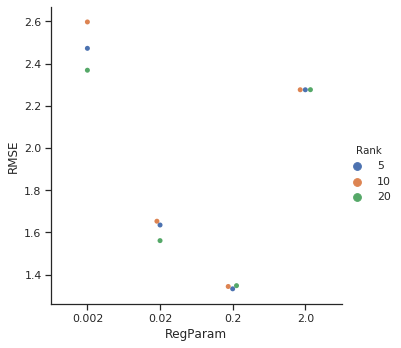

In [62]:
sns.catplot(x="RegParam", y="RMSE", hue="Rank", kind="swarm", data=metrics_df)

### We now build a final model with the best model parameters and compute its RMSE and R2 values

In [63]:
als_final = ALS(maxIter=5, regParam=0.2, rank = 20, userCol="user_id_num", itemCol="business_id_num", ratingCol="rating",
          coldStartStrategy="drop", nonnegative=True)
model_final = als_final.fit(spark_train)
predictions_final = model_final.transform(spark_test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="rating",
                                predictionCol="prediction")
rmse_als = evaluator.evaluate(predictions_final)
r2_als = evaluator_r2.evaluate(predictions_final)
print("RMSE = ",rmse_als)
print("R2 = ",r2_als)



RMSE =  1.3471860445630452
R2 =  0.013126329569395856


### Since ALS generates the top 5 recommendations for each user, we can directly use that to compute coverage on the dataset

In [0]:
recommendations_als = model_final.recommendForAllUsers(5)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def recommended_movies(recommendations):
    movie_ids = [str(i[0]) for i in recommendations]
    return ','.join(movie_ids)

recommended_movies_udf = udf(recommended_movies, StringType())

In [0]:
recommendations1 = recommendations_als.withColumn('restaurants',recommended_movies_udf(recommendations_als['recommendations']))
#Convert the recommendations list to a userId, movieId combination
recommendations2 = recommendations1.select('user_id_num','restaurants')
recommendations2 = recommendations2.withColumn('restaurant',explode(split('restaurants',',')))

In [0]:
unique_rest = recommendations2.select('restaurant').dropDuplicates()
pd_unique_rest = unique_rest.toPandas()

In [68]:
print("Catalog coverage:",(len(pd_unique_rest)/len(set(sample_df['business_id'])))*100,"%")

Catalog coverage: 8.860759493670885 %


### We see that our model not only performs better in terms of RMSE and R2, it also has a better coverage than the ALS baseline model

# Bias baseline

### We now build the bias only baseline model from the surprise package

In [0]:
#baseline model using surprise BaseLine
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split


algo = BaselineOnly()
reader = Reader()

In [0]:
data_train = Dataset.load_from_df(train_baseline, reader)
data_test = Dataset.load_from_df(test_baseline, reader)

In [71]:
trainset = data_train.build_full_trainset()
algo.fit(trainset)

Estimating biases using als...


In [0]:
trainset, testset = train_test_split(data_test, test_size=1.0)
predictions = algo.test(testset)

In [0]:
pred_vals = []
for i in predictions:
  pred_vals.append(i.est)

In [74]:
baseline_bias_rmse = math.sqrt(mean_squared_error(pred_vals, test['rating']))
baseline_bias_r2 = goodness_of_fit(pred_vals,np.array(test['rating']))
print("RMSE = ",baseline_bias_rmse)
print("R2 = ",baseline_bias_r2)

RMSE =  1.43398790795845
R2 =  -0.11675941141868962


### Our model performs better than the Bias only baseline model, with significantly better RMSE and R2 values  
  
### We now compute the catalog coverage in the same manner as we did for our Wide and Deep model

In [0]:
recs_set = not_reviewed_sample[['user_id_num','business_id_num','pred_rating']]
data_rec = Dataset.load_from_df(recs_set, reader)
train_rec, data_rec = train_test_split(data_rec, test_size=1.0)

In [0]:
recs = algo.test(data_rec)
recs_val = []
for i in recs:
  recs_val.append(i.est)
not_reviewed_sample['pred_rating_bias_only'] = recs_val

In [0]:
top_5_bias = not_reviewed_sample.groupby(["user_id"]).apply(pd.DataFrame.sort_values, 'pred_rating_bias_only').reset_index(drop=True)
top_5_bias_recs = top_5_bias.groupby(["user_id"]).tail(5)

In [78]:
print("Catalog Coverage for the sample:",(len(set(top_5_bias_recs['business_id']))/len(set(not_reviewed_1['business_id'])))*100,"%")

Catalog Coverage for the sample: 100.0 %


### We see that the bias only baseline model has a catalog coverage of 100%. However, since this model has a very poor R2 value, we feel that the recommendations it makes are not of high quality and hence is able to obtain 100% coverage
